In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import cv2 as cv
import glob
# from skimage import io
image_size = 56

In [2]:
transform2 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
my_transform = transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(), transforms.Resize((image_size,image_size)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
class customDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.label.iloc[idx, 0])

        image = cv.imread(img_name)
        labels = self.label.iloc[idx, 1]
        labels = np.array(labels)
        sample = {'image': image, 'label': labels}

        if sample['image'] is not None:
            if self.transform:
                sample['image'] = self.transform(sample['image'])

        return sample

In [4]:
#CUSTOM TRAIN DATASET
# custom_dataset = customDataset(csv_file='./dataset/labels.csv',root_dir='./dataset/images/',transform=transforms.Compose([Rescale(256),ToTensor()]))
custom_training_dataset = []
temp = customDataset(csv_file='./dataset/train/labels.csv',root_dir='./dataset/train/images/',transform=my_transform)

images = glob.glob('./dataset/train/images/*.jpg')
images.sort()
# count = []
for i in range(len(temp)):
    sample = temp[i]
#     print(sample.keys())
    if sample['image'] is not None:
        custom_training_dataset.append(sample)
#         print(i, sample['image'].shape, sample['label'].shape, sample['label'][0][0])
#     else:
#         print(i)
#         count.append(i)
#     print(sample)
# print(count)

In [11]:
#CUSTOM TEST DATASET
# custom_dataset = customDataset(csv_file='./dataset/labels.csv',root_dir='./dataset/images/',transform=transforms.Compose([Rescale(256),ToTensor()]))
custom_testing_dataset = []
temp = customDataset(csv_file='./dataset/test/labels.csv',root_dir='./dataset/test/images/',transform=my_transform)

images = glob.glob('./dataset/test/images/*.jpg')
images.sort()
# count = []
for i in range(len(temp)):
    sample = temp[i]
#     print(sample.keys())
    if sample['image'] is not None:
        custom_testing_dataset.append(sample)
#         print(i, sample['image'].shape, sample['label'].shape, sample['label'][0][0])
#     else:
#         print(i)
#         count.append(i)
#     print(sample)
# print(count)

In [12]:
# trainset = datasets.MNIST('~/Documents/Sem9/TA-COL780/Pytorch_tutorial/', download=True, train=True, transform=transform)
# testset = datasets.MNIST('~/Documents/Sem9/TA-COL780/Pytorch_tutorial/', download=True, train=False, transform=transform2)
trainloader = torch.utils.data.DataLoader(custom_training_dataset, batch_size=128, shuffle=True)
print(len(custom_training_dataset))
print(len(trainloader))
testloader = torch.utils.data.DataLoader(custom_testing_dataset, batch_size=64, shuffle=True)
print(len(custom_testing_dataset))
print(len(testloader))
classes = ('1','2','3')

3631
29
610
10


torch.Size([128, 1, 56, 56])
torch.Size([128])


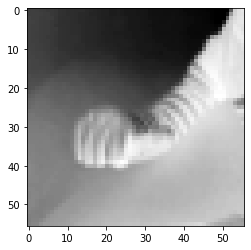

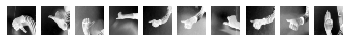

In [13]:
dataiter = iter(trainloader)
n = dataiter.next()
images = n['image']
labels = n['label']

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');  
figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images+1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

torch.Size([64, 1, 56, 56])
torch.Size([64])


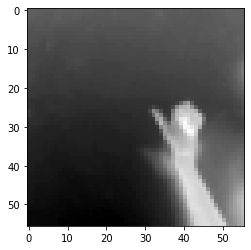

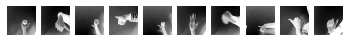

In [14]:
dataiter = iter(testloader)
n = dataiter.next()
images = n['image']
labels = n['label']

print(images.shape)
print(labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');  
figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images+1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [15]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 12 * 12, 300)  
        self.fc2 = nn.Linear(300, 120)
        self.fc3 = nn.Linear(120, 4)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         print("inside forward")
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=4, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[1,    28] loss: 0.862
Accuracy of the network on the test images: 53 % 328 610
correct: [120, 208, 0]
incorrect: [98, 59, 125]
Accuracy of the network on the train images: 63 % 2322 3631
[1,     6] loss_val: 1.017
[2,    28] loss: 0.841
Accuracy of the network on the test images: 55 % 336 610
correct: [135, 201, 0]
incorrect: [83, 66, 125]
Accuracy of the network on the train images: 65 % 2362 3631
[2,     6] loss_val: 1.019
[3,    28] loss: 0.820
Accuracy of the network on the test images: 52 % 321 610
correct: [110, 211, 0]
incorrect: [108, 56, 125]
Accuracy of the network on the train images: 65 % 2378 3631
[3,     6] loss_val: 0.996
[4,    28] loss: 0.799
Accuracy of the network on the test images: 54 % 333 610
correct: [123, 210, 0]
incorrect: [95, 57, 125]
Accuracy of the network on the train images: 66 % 2427 3631
[4,     6] loss_val: 0.997
[5,    28] loss: 0.776
Accuracy of the network on the test images: 56 % 344 610
correct: [135, 209, 0]
incorrect: [83, 58, 125]
Accuracy of

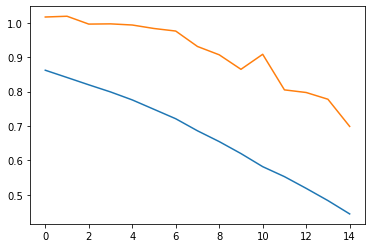

In [22]:
mini_batch = 28
mini_batch_loss = 6
loss_values = []
loss_values_val = []
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_val =0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs_train = data['image']
        labels_train = data['label']
        # make the parameter gradients zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_train = net(inputs_train)
        loss_train = criterion(outputs_train, labels_train)
        loss_train.backward()
        optimizer.step()

        # print statistics
        running_loss += loss_train.item()
        if i % mini_batch == mini_batch-1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / mini_batch))
            loss_values.append(running_loss/mini_batch)
            running_loss = 0.0
         
    correct = 0
    total = 0
    classes = [0,0,0]
    incorrect = [0,0,0]
    with torch.no_grad():
        for data in testloader:
            images = data['image']
            labels = data['label']
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            for j in range(len(labels)):
                if predicted[j]==labels[j]:
                    classes[labels[j]-1]+=1
                else:
                    incorrect[labels[j]-1]+=1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total), correct, total)
    print("correct:",classes)
    print("incorrect:",incorrect)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images = data['image']
            labels = data['label']
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (
        100 * correct / total),correct,total)

    for i, data in enumerate(testloader,0):
        inputs_val = data['image']
        labels_val = data['label']

        outputs_val = net(inputs_val)
        loss_val = criterion(outputs_val, labels_val)

        # print statistics
        running_loss_val += loss_val.item()
        if i % mini_batch_loss == mini_batch_loss-1:    # print every 200 mini-batches
            print('[%d, %5d] loss_val: %.3f' %
                  (epoch + 1, i + 1, running_loss_val / mini_batch_loss))
            loss_values_val.append(running_loss_val/mini_batch_loss)
            running_loss_val = 0.0
        
# print(loss_values)        
plt.plot(loss_values)
plt.plot(loss_values_val)

print('Finished Training')

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images = data['image']
        labels = data['label']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 83 %


In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images = data['image']
        labels = data['label']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 65 %


In [28]:
MODEL_PATH = './model'
# print("Model's state_dict:")
# for param_tensor in net.state_dict():
#     print(param_tensor, "\t", net.state_dict()[param_tensor].size())
    
#print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])
    
torch.save(net.state_dict(), MODEL_PATH)
print("model saved as ",MODEL_PATH)

model saved as  ./model


In [29]:
# model = torch.load(MODEL_PATH)
model = Net()
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=4, bias=True)
)

In [48]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images = data['image']
        labels = data['label']
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
correct = 0
total = 0
predictions = {'image':[],'prediction':[]}
with torch.no_grad():
    for data in testloader:
        images = data['image']
        labels = data['label']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
#         print(np.array(predicted))
        predictions['prediction'] = list(list(predictions['prediction']) + list(np.array(predicted)))
#         predictions['image'] = list(list(predictions['image'])+list(np.array(images)))
        total += predicted.size(0)
        correct += (predicted == labels).sum().item()
print(predictions)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 83 %
{'image': [], 'prediction': [2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 2, 1, 3, 2, 1, 1, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 3, 2, 3, 1, 2, 3, 2, 2, 2, 2, 2, 3, 1, 3, 3, 2, 1, 2, 2, 3, 3, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2, 2, 3, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 3, 1, 1, 2, 2, 1, 1, 3, 1, 1, 1, 1, 3, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 3, 3, 2, 2, 2, 1, 2, 1, 3, 2, 2, 2, 3, 1, 1, 2, 1, 1, 3, 3, 2, 2, 1, 2, 2, 2, 1, 1, 3, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 3, 3, 2, 2, 2, 2, 1, 3, 2, 3, 3, 2, 1, 1, 3, 1, 1, 3, 1, 2, 3, 2, 2, 1, 1, 3, 1, 2, 2, 1, 2, 2, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 3, 2, 1, 2, 1, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 3, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 3, 1, 1, 1, 